In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

In [2]:
def combine_params(p_fixed, p_est):
    CI, GEZI, tauG = p_fixed
    tc, SI, EGP, VGi, km = p_est
    return [tc, km, tauG, EGP, CI, GEZI, SI, VGi]

In [3]:
def ident_model(t, u, p, d_t, u_t, t_range):
    # states
    ISC, IP, IEFF, G, D1, D2 = u

    # parameters
    tc, km, tauG, EGP, CI, GEZI, SI, VGi = p

    # identifiability
    k1 = k2 = p2 = tc


    # meal intake
    d_ti = d_t[np.abs(t_range - t).argmin()]

    # insulin infusion rate
    u_ti = u_t[np.abs(t_range - t).argmin()]

    # dynamics
    dISC = k1 * ((u_ti / CI) - ISC)
    dIP = k2 * (ISC - IP)

    dD1 = (d_ti - (D1 / tauG))
    dD2 = ((D1 - D2) / tauG)

    RA = D2 * km * VGi

    dIEFF = (-p2 * IEFF + p2 * SI * IP)
    dG = (-(IEFF + GEZI) * G + EGP + RA)

    return [dISC, dIP, dIEFF, dG, dD1, dD2]

In [4]:
def ts2s(h, m=0, s=0):
    return h * 60 * 60 + m * 60 + s

In [5]:
# fixed parameters
CI = 1.0
GEZI = 0.0
tauG = 1.0

p_fixed = [CI, GEZI, tauG]

In [6]:
# estimated parameters
tc = 0.023
SI = 0.0017
EGP = 1.17
VGi = 0.0082
km = 0.0226

p_est = [tc, SI, EGP, VGi, km]

In [18]:
# timespan
t_span = [0, ts2s(30)] # 30 hours
t_eval = np.arange(*t_span)

# meals
d_t = np.zeros_like(t_eval)
d_t[ts2s(8)] = 72
d_t[ts2s(11, 30)] = 36
d_t[ts2s(13, 15)] = 131
d_t[ts2s(18, 00)] = 51
d_t[ts2s(22, 00)] = 70

# insulin injections
u_t = np.zeros_like(t_eval)
u_t[ts2s(8)] = 72 // 5
u_t[ts2s(11, 30)] = 36 // 5
u_t[ts2s(13, 15)] = 131 // 5
u_t[ts2s(18, 00)] = 51 // 5
u_t[ts2s(22, 00)] = 70 // 5

In [19]:
# initial conditions
ISC0 = 0.0
IP0 = 0.0
IEFF0 = 20.0
G0 = 100
D10 = 0.0
D20 = 0.0

u0 = [ISC0, IP0, IEFF0, G0, D10, D20]

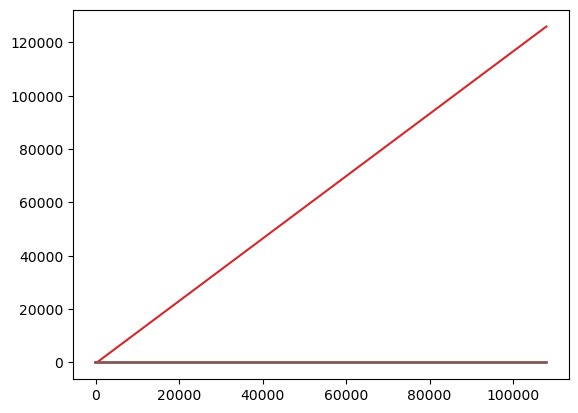

In [22]:
sol = solve_ivp(ident_model, t_span, u0, t_eval=t_eval, args=(combine_params(p_fixed, p_est), d_t, u_t, t_eval))

plt.plot(sol.t, sol.y.T)
plt.show()